#### imports

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import os
import IPython
from scipy.io import wavfile 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IPython.display.Audio(r"raw_data\positive\1.wav")

In [3]:
IPython.display.Audio(r"raw_data\negative\1.wav")

In [4]:
IPython.display.Audio(r"raw_data\background\1.wav")

#### From Audio recordings to Spectrograms

In [5]:
def graph_spectrogram(wav_file):
    rate, data = wavfile.read(wav_file)  # rate=44100 - sampling rate (https://en.wikipedia.org/wiki/44,100_Hz)
    
    nfft = 200          # fft window length
    fs = 8000           # sampling frequency
    noverlap = 120      # overlap between windows
    nchannels = data.ndim
    
    if nchannels == 1:
        pxx, freq, bins, im = plt.specgram(data, nfft, fs, noverlap=noverlap)
    elif nchannels == 2:
        pxx, freq, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap=noverlap)
    
    # print('file duration in seconds %s' %(len(data)/rate))
    return pxx

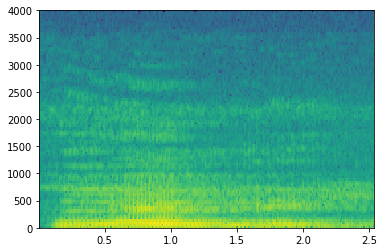

In [6]:
x = graph_spectrogram(r"raw_data\positive\1.wav")

In [7]:
# we will input 10 sec audio to nn therefore
Tx = 5511    # number of time step input to the model from the spectrogram
n_freq = 101 # number of frequencies input to the model at each time step of the spectrogram
Ty = 1375    # number of time steps in the output of our model

###### how we got above value? We have 10 sec audio in raw_data\background\1.wav

(101, 5511)

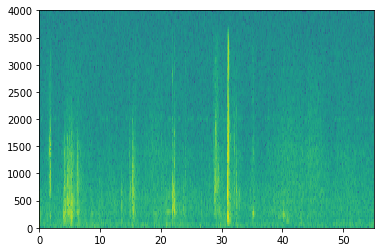

In [8]:
x = graph_spectrogram(r"raw_data\background\1.wav")
x.shape

# Generating training samples

#### 1. Read wav files

In [9]:
positive = []
negative = []
background = []

# positive samples
for file in os.listdir(r"raw_data\positive"):
    if file.endswith("wav"):
        pos = AudioSegment.from_wav(r"raw_data\positive\\" + file)
        positive.append(pos)
        
# negative samples
for file in os.listdir(r"raw_data\negative"):
    if file.endswith("wav"):
        neg = AudioSegment.from_wav(r"raw_data\negative\\" + file)
        negative.append(neg)

# background samples
for file in os.listdir(r"raw_data\background"):
    if file.endswith("wav"):
        bak = AudioSegment.from_wav(r"raw_data\background\\" + file)
        background.append(bak)

In [10]:
print("background len: " + str(len(background[0])))
print("positive[0] len: " + str(len(positive[0])))
print("positive[1] len: " + str(len(positive[1])))

background len: 10000
positive[0] len: 462
positive[1] len: 371


#### 2. Overlaying positive and negative samples over background

In [11]:
def get_random_time_segment(seg_ms):
    
    seg_start = np.random.randint(low=0, high=10000-seg_ms)
    seg_end = seg_start + seg_ms - 1
    
    return seg_start, seg_end

In [12]:
def is_overlapping(seg_time, prev_segs):
    
    seg_start, seg_end = seg_time
    
    overlap = False
    
    for prev_start, prev_end in prev_segs:
        if seg_start <= prev_end and seg_end >= prev_start:
            overlap = True
            
    return overlap

In [13]:
# test is_overlapping method
print(is_overlapping((950, 1430), [(2000, 2550), (260, 949)]))
print(is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)]))

False
True


In [14]:
# method to overlay
def insert_audio_clip(background, audio_clip, prev_segs):
    """
    background     10 sec background noise audio
    audio_clip     clip with positive or negative sample
    prev_seg       time where autdio sample has already placed
    
    return         updated 10 seconds audio
    """
    
    # get time in ms
    seg_ms = len(audio_clip)
    
    # get random place time for this clip
    seg_time = get_random_time_segment(seg_ms)
    
    # check if seg_time overlaps to previous seg, if yes then find another place
    while is_overlapping(seg_time, prev_segs):
        seg_time = get_random_time_segment(seg_ms)
    
    # append new seg to prev seg
    prev_segs.append(seg_time)
    
    # lets overlay
    new_background = background.overlay(audio_clip, position = seg_time[0])
    
    return new_background, seg_time

In [15]:
audio_clip, seg_time = insert_audio_clip(background[0], positive[0], [(3790, 4400)])
#audio_clip.export(r"raw_data\training_data\1.wav", format="wav")
print("segment time: " + str(seg_time))
#IPython.display.Audio(r"raw_data\training_data\1.wav")

segment time: (4862, 5323)


#### 3. Create expected output Y by inserting 1 where positive keyword was triggered, 0 otherwise

In [16]:
def insert_ones(y, seg_end_ms):
    
    seg_end_y = int(seg_end_ms * Ty / 10000.0)
    
    for i in range(seg_end_y + 1, seg_end_y + 51): # 50 1s once keyword detected
        if i < Ty:
            y[0, i] = 1
            
    return y

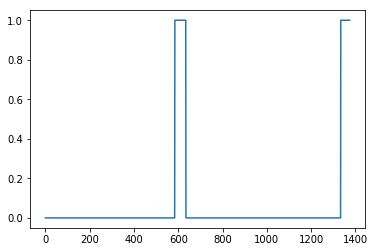

In [17]:
# test insert_ones method
inserted_one = insert_ones(np.zeros((1, Ty)), 9700)
inserted_one = insert_ones(inserted_one, 4251)
plt.plot(inserted_one[0,:])

In [18]:
def match_target_amp(sound, target_dBFS):
    dBFS_Change = target_dBFS - sound.dBFS
    return sound.apply_gain(dBFS_Change)

#### 4. Finally, lets create 1 full training sample

In [19]:
def create_training_sample(background, positive, negative, idx):
    
    """
    background      path 10 second audio
    positive        path positive sample audio
    negative        path negative sample audio
    
    returns:
    x               spectrogram of training sample
    y               label at each time step of the spectrogram
    """
    
    # Make backgound quieter
    background = background - 20
    
    # initialize ouput vector as zeros
    y = np.zeros((1, Ty))
    
    # initialize seg times as empty list
    prev_seg = []
    
    # select 0-4 random positive samples
    nr_of_positve = np.random.randint(0, 5)
    random_indx = np.random.randint(len(positive), size=nr_of_positve)
    random_positives = [positive[i] for i in random_indx]
    
    # lets overlay this sample over background
    for random_positive in random_positives:
        # insert positive sample on background
        background, seg_time = insert_audio_clip(background, random_positive, prev_seg)
        
        # retreive seg_start and seg_end from seg_time
        seg_start, seg_end = seg_time
        
        # insert ones in y
        y = insert_ones(y, seg_end)
        
    # select 0-2 random negative samples
    nr_of_negative = np.random.randint(0, 3)
    random_idx = np.random.randint(len(negative), size=nr_of_negative)
    random_negatives = [negative[i] for i in random_idx]
    
    # lets overlay this sample over background
    for random_negative in random_negatives:
        # insert negative sample on backgound
        background, _ = insert_audio_clip(background, random_negative, prev_seg)
        
    
    # standarize the volume of the audio clip
    backgound = match_target_amp(background, -20.0)
    
    # file name
    name = r"raw_data\training_data\X" + str(idx) + ".wav"
    
    # save on disk
    background = backgound.export(name, format="wav")
    
    # get spectrogram
    x = graph_spectrogram(name)
        
    return x, y

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


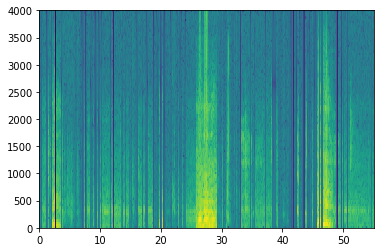

In [20]:
X = []
Y = []
for i in range(0,201):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


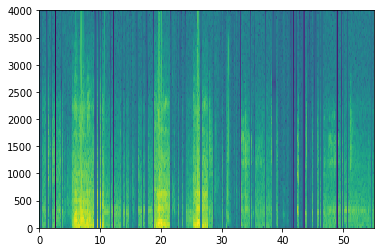

In [21]:
for i in range(201,401):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


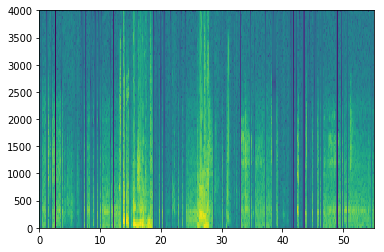

In [22]:
for i in range(401,601):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


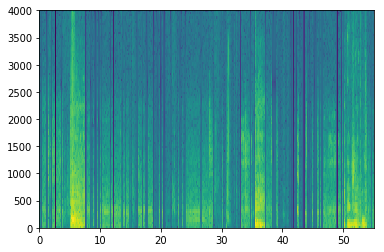

In [23]:
for i in range(601,801):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


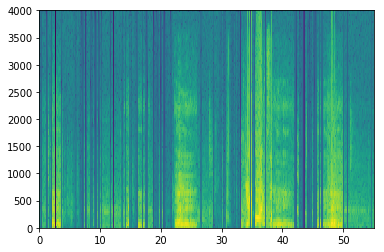

In [24]:
for i in range(801,1001):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


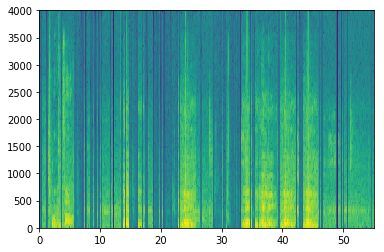

In [25]:
for i in range(1001,1201):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


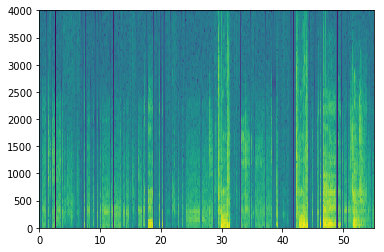

In [26]:
for i in range(1201,1401):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


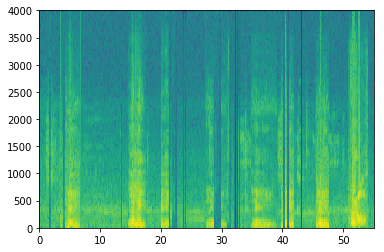

In [27]:
for i in range(1401,1601):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


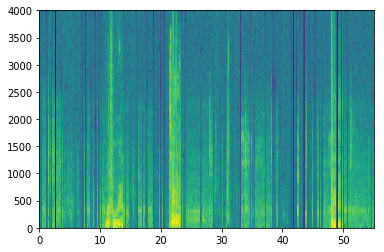

In [28]:
for i in range(1601,1801):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


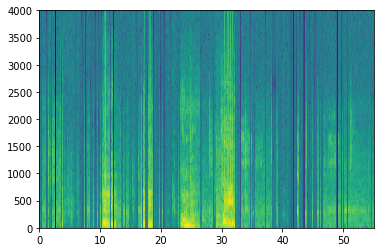

In [29]:
for i in range(1801,2000):
    x, y = create_training_sample(background[i%len(background)], positive, negative, i)
    X.append(x)
    Y.append(y)

In [30]:
X = np.asarray(X)
Y = np.asarray(Y)

In [31]:
np.save(r"raw_data\np_array\X.npy", X)
np.save(r"raw_data\np_array\Y.npy", Y)

In [32]:
X = np.load(r"raw_data\np_array\X.npy")
Y = np.load(r"raw_data\np_array\Y.npy")

In [33]:
# import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [34]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, 15, strides=4)(X_input)             # CONV1D
    X = BatchNormalization(axis=-1)(X)                  # Batch normalization
    X = Activation('relu')(X)                           # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)    # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)    # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                         # Batch normalization
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model

In [35]:
model = model(input_shape = (Tx, n_freq))

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1375, 128)         0         
__________

In [37]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [38]:
J = X.swapaxes(1,2)

In [39]:
J.shape

(2001, 5511, 101)

In [40]:
K = Y.swapaxes(1,2)

In [41]:
K.shape

(2001, 1375, 1)

In [146]:
model.fit(J, K, batch_size = 32, epochs=1)  # 90

Epoch 1/1
2001/2001 [==============================] - 133s 67ms/step - loss: 0.6796 - acc: 0.8808


In [139]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    #print(predictions)
    print(np.amax(predictions))
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [140]:
chime_file = r"raw_data\chime\chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 45 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 30:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export(r"raw_data\chime\chime_output.wav", format='wav')

In [141]:
IPython.display.Audio(r"raw_data\training_data\X15.wav")

c:\programdata\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


0.40134785


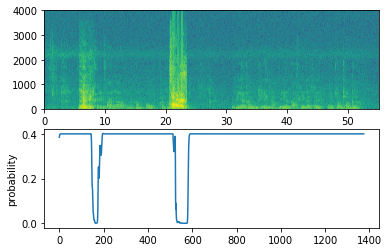

In [145]:
filename = r"raw_data\training_data\X612.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.4008389)
IPython.display.Audio(r"raw_data\chime\chime_output.wav")

In [138]:
model.save(r"raw_data\chime\chimModel_pc_88_06.h5")